In [3]:
#one level up into project folder
import os
#os.chdir("..")

#print("Current working directory:", os.getcwd())

In [5]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

import joblib
import mlflow
import mlflow.sklearn  

from vocalbaby.utils.ml_utils.metric.classification_metric import get_classification_score

import dagshub
dagshub.init(repo_owner='arunps12', repo_name='VisionInfantNet', mlflow=True)

import mlflow
with mlflow.start_run():
  mlflow.log_param('parameter name', 'value')
  mlflow.log_metric('metric name', 1)


Accessing as arunps12

Initialized MLflow to track repo "arunps12/VisionInfantNet"

Repository arunps12/VisionInfantNet initialized!

2025/12/06 17:06:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run glamorous-pug-901 at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/afbbedaf8a584c56bae3a32d128b2b88.
2025/12/06 17:06:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.


In [7]:
import os

def get_latest_artifact(root_dir="artifacts"):
    """
    Returns full path to the most recent timestamped artifact folder.
    Example folder names: '12_06_2025_14_47_14'
    """
    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"{root_dir} does not exist.")

    # list subdirectories
    subdirs = [
        os.path.join(root_dir, d)
        for d in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, d))
    ]

    if not subdirs:
        raise FileNotFoundError(f"No artifact folders found in {root_dir}.")

    # sort by creation time
    latest = max(subdirs, key=os.path.getmtime)
    return latest

latest_artifact_dir = get_latest_artifact()

print("Latest artifact directory:")
print(latest_artifact_dir)


Latest artifact directory:
artifacts/12_06_2025_14_47_14


In [8]:
latest_artifact_dir = get_latest_artifact()
print("Latest artifact directory:")
print(latest_artifact_dir)

Latest artifact directory:
artifacts/12_06_2025_14_47_14


In [9]:
feature_root = os.path.join(latest_artifact_dir, "data_transformation", "features")

paths = {
    "egemaps_train": f"{feature_root}/train_compare_features.npy",
    "egemaps_valid": f"{feature_root}/valid_compare_features.npy",

    "boaw_train": f"{feature_root}/train_boaw_features.npy",
    "boaw_valid": f"{feature_root}/valid_boaw_features.npy",

    "fv_train": f"{feature_root}/train_fv_features.npy",
    "fv_valid": f"{feature_root}/valid_fv_features.npy",

    "panns_train": f"{feature_root}/train_panns_features.npy",
    "panns_valid": f"{feature_root}/valid_panns_features.npy",

    "resnet_train": f"{feature_root}/train_image_embeddings.npy",
    "resnet_valid": f"{feature_root}/valid_image_embeddings.npy",

    "labels_train": f"{feature_root}/train_labels.npy",
    "labels_valid": f"{feature_root}/valid_labels.npy",
}

paths


{'egemaps_train': 'artifacts/12_06_2025_14_47_14/data_transformation/features/train_compare_features.npy',
 'egemaps_valid': 'artifacts/12_06_2025_14_47_14/data_transformation/features/valid_compare_features.npy',
 'boaw_train': 'artifacts/12_06_2025_14_47_14/data_transformation/features/train_boaw_features.npy',
 'boaw_valid': 'artifacts/12_06_2025_14_47_14/data_transformation/features/valid_boaw_features.npy',
 'fv_train': 'artifacts/12_06_2025_14_47_14/data_transformation/features/train_fv_features.npy',
 'fv_valid': 'artifacts/12_06_2025_14_47_14/data_transformation/features/valid_fv_features.npy',
 'panns_train': 'artifacts/12_06_2025_14_47_14/data_transformation/features/train_panns_features.npy',
 'panns_valid': 'artifacts/12_06_2025_14_47_14/data_transformation/features/valid_panns_features.npy',
 'resnet_train': 'artifacts/12_06_2025_14_47_14/data_transformation/features/train_image_embeddings.npy',
 'resnet_valid': 'artifacts/12_06_2025_14_47_14/data_transformation/features/v

In [10]:
# --- Low-Level Audio Features ---
X_train_egemaps = np.load(paths["egemaps_train"])
X_valid_egemaps = np.load(paths["egemaps_valid"])

X_train_boaw = np.load(paths["boaw_train"])
X_valid_boaw = np.load(paths["boaw_valid"])

X_train_fv = np.load(paths["fv_train"])
X_valid_fv = np.load(paths["fv_valid"])

# --- Deep Audio Embeddings ---
X_train_panns = np.load(paths["panns_train"])
X_valid_panns = np.load(paths["panns_valid"])

# --- Image Embeddings ---
X_train_resnet = np.load(paths["resnet_train"])
X_valid_resnet = np.load(paths["resnet_valid"])

# --- Labels ---
y_train = np.load(paths["labels_train"])
y_valid = np.load(paths["labels_valid"])

print("Loaded all feature tensors successfully!")


Loaded all feature tensors successfully!


In [11]:
print("Shapes:")
print("eGeMAPS:", X_train_egemaps.shape, X_valid_egemaps.shape)
print("BoAW:", X_train_boaw.shape, X_valid_boaw.shape)
print("FV:", X_train_fv.shape, X_valid_fv.shape)
print("PANNs:", X_train_panns.shape, X_valid_panns.shape)
print("ResNet:", X_train_resnet.shape, X_valid_resnet.shape)
print("y_train / y_valid:", y_train.shape, y_valid.shape)

Shapes:
eGeMAPS: (3600, 88) (3580, 88)
BoAW: (3600, 1000) (3580, 1000)
FV: (3600, 640) (3580, 640)
PANNs: (3600, 2048) (3580, 2048)
ResNet: (3600, 2048) (3580, 2048)
y_train / y_valid: (3600,) (3580,)


In [12]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_valid_enc = label_encoder.transform(y_valid)

print("Label encoding mapping:")
for orig, enc in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{orig} → {enc}")


#  confusion matrix plotting
def plot_confusion_matrix_local(cm, class_names, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Global imputer creator
def impute_train_valid(X_train, X_valid, strategy="median"):
    imputer = SimpleImputer(strategy=strategy)
    X_train_imp = imputer.fit_transform(X_train)
    X_valid_imp = imputer.transform(X_valid)
    return X_train_imp, X_valid_imp


Label encoding mapping:
Canonical → 0
Crying → 1
Junk → 2
Laughing → 3
Non-canonical → 4


In [56]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks


def hybrid_sampler(
    X,
    y,
    smote_strategy,
    final_strategy,
    random_state: int = 42,
):
    """
    Hybrid sampler: SMOTE -> custom RandomUnderSampler -> TomekLinks.
    - smote_strategy: dict {class_label: n_samples_after_smote}
    - final_strategy: dict {class_label: n_samples_final}
    """

    orig_counts = Counter(y)
    print("[HybridSampler] Original:", orig_counts)
    print("[HybridSampler] SMOTE target:", smote_strategy)
    print("[HybridSampler] Final target:", final_strategy)

        # Validate strategies
    for cls in final_strategy:
        if smote_strategy[cls] < orig_counts[cls]:
            raise ValueError(
                f"smote_strategy[{cls}] = {smote_strategy[cls]} "
                f"< original count {orig_counts[cls]}"
            )
        if final_strategy[cls] > smote_strategy[cls]:
            raise ValueError(
                f"final_strategy[{cls}] = {final_strategy[cls]} "
                f"> smote_strategy[{cls}] = {smote_strategy[cls]}"
            )

    # 1) SMOTE
    sm = SMOTE(random_state=random_state, sampling_strategy=smote_strategy)
    X_sm, y_sm = sm.fit_resample(X, y)
    print("[HybridSampler] After SMOTE:", Counter(y_sm))

    # 2) Custom undersampling
    rus = RandomUnderSampler(
        random_state=random_state,
        sampling_strategy=final_strategy,
    )
    X_ru, y_ru = rus.fit_resample(X_sm, y_sm)
    print("[HybridSampler] After undersampling:", Counter(y_ru))

    # 3) TomekLinks cleaning
    tl = TomekLinks()
    X_clean, y_clean = tl.fit_resample(X_ru, y_ru)
    print("[HybridSampler] After TomekLinks:", Counter(y_clean))

    return X_clean, y_clean


In [61]:
from collections import Counter 
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from sklearn.utils.class_weight import compute_class_weight
import numpy as np



def resample_data(X_train, y_train_enc, method: str):
    """
    Supported:
        - none
        - class_weights
        - smote
        - smote_tomek
        - smote_then_tomek
        - undersampling
        - smote_enn
        - hybrid    
    """
    print(f"\n[Imbalance] Method = {method}")
    print("  Original class distribution:", Counter(y_train_enc))

    X_res, y_res = X_train, y_train_enc
    sample_weight = None

    if method == "none":
        return X_train, y_train_enc, None

    elif method == "class_weights":
        classes = np.unique(y_train_enc)
        cw = compute_class_weight(
            class_weight="balanced",
            classes=classes,
            y=y_train_enc
        )
        class_weight_dict = dict(zip(classes, cw))
        sample_weight = np.array([class_weight_dict[c] for c in y_train_enc])
        print("  Using class weights:", class_weight_dict)
        return X_train, y_train_enc, sample_weight

    elif method == "smote":
        try:
            sm = SMOTE(random_state=42)
            X_res, y_res = sm.fit_resample(X_train, y_train_enc)
        except ValueError as e:
            print(f"  [WARN] SMOTE failed: {e}")
            print("         Falling back to no resampling.")
            return X_train, y_train_enc, None

    elif method == "smote_tomek":
        try:
            smt = SMOTETomek(random_state=42)
            X_res, y_res = smt.fit_resample(X_train, y_train_enc)
        except ValueError as e:
            print(f"  [WARN] SMOTE-Tomek failed: {e}")
            print("         Falling back to no resampling.")
            return X_train, y_train_enc, None

    elif method == "smote_then_tomek":
        try:
            sm = SMOTE(random_state=42)
            X_res, y_res = sm.fit_resample(X_train, y_train_enc)
            print("  After SMOTE:", Counter(y_res))
            tl = TomekLinks()
            X_res, y_res = tl.fit_resample(X_res, y_res)
        except ValueError as e:
            print(f"  [WARN] SMOTE + TomekLinks failed: {e}")
            print("         Falling back to no resampling.")
            return X_train, y_train_enc, None

    elif method == "undersampling":
        rus = RandomUnderSampler(random_state=42)
        X_res, y_res = rus.fit_resample(X_train, y_train_enc)

    elif method == "smote_enn":
        try:
            smote_enn = SMOTEENN(random_state=42)
            X_res, y_res = smote_enn.fit_resample(X_train, y_train_enc)
        except ValueError as e:
            print(f"  [WARN] SMOTEENN failed: {e}")
            print("         Falling back to no resampling.")
            return X_train, y_train_enc, None

    
    elif method == "hybrid":
        try:
           
            final_target = {
                0: 900,   # Canonical
                1: 900,   # Crying
                2: 1400,  # Junk
                3: 800,   # Laughing
                4: 1200,  # Non-canonical
            }
            orig = Counter(y_train_enc)
            smote_target = {
                cls: max(orig[cls], final_target[cls])
                for cls in final_target
            }
            X_res, y_res = hybrid_sampler(
                X_train,
                y_train_enc,
                smote_strategy=smote_target,
                final_strategy=final_target,
                random_state=42,
            )
        except ValueError as e:
            print(f"  [WARN] HybridSampler failed: {e}")
            print("         Falling back to no resampling.")
            return X_train, y_train_enc, None

    else:
        raise ValueError(f"Unknown imbalance method: {method}")

    print("  New class distribution:", Counter(y_res))
    return X_res, y_res, sample_weight


In [59]:
def run_xgb_experiment_for_feature(
    feature_name: str,
    X_train_raw: np.ndarray,
    X_valid_raw: np.ndarray,
    imbalance_method: str = "none",
    n_estimators: int = 300,
    max_depth: int = 6,
    lr: float = 0.05,
):

    # 1) Impute NaNs
    X_train_imp, X_valid_imp = impute_train_valid(X_train_raw, X_valid_raw, strategy="median")

    # 2) Apply imbalance method on training set only
    X_train_bal, y_train_bal, sample_weight = resample_data(X_train_imp, y_train_enc, method=imbalance_method)

    # 3) Build XGBoost model
    model = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=lr,
        max_depth=max_depth,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        tree_method="auto",
        n_jobs=-1,
        random_state=42,
    )

    run_name = f"XGB_{feature_name}_{imbalance_method}"
    with mlflow.start_run(run_name=run_name):

        # Fit
        if imbalance_method == "class_weights" and sample_weight is not None:
            model.fit(X_train_bal, y_train_bal, sample_weight=sample_weight)
        else:
            model.fit(X_train_bal, y_train_bal)

        # Predict on validation (encoded → decode)
        y_pred_enc = model.predict(X_valid_imp)
        y_pred = label_encoder.inverse_transform(y_pred_enc)

        # Metrics
        acc = accuracy_score(y_valid, y_pred)
        metrics = get_classification_score(y_valid, y_pred)

        print(f"\n=== XGBoost on {feature_name} | imbalance={imbalance_method} ===")
        print(f"Accuracy: {acc:.4f}")
        print("Weighted F1:", metrics.f1_score)
        print("Weighted Precision:", metrics.precision_score)
        print("Weighted Recall:", metrics.recall_score)
        print("UAR:", metrics.uar)

        # Confusion matrix
        class_names = list(label_encoder.classes_)
        cm = confusion_matrix(y_valid, y_pred)
        plot_confusion_matrix_local(cm, class_names, f"XGB {feature_name} ({imbalance_method})")

        # Save confusion matrix PNG & log
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        cm_csv = f"cm_xgb_{feature_name}_{imbalance_method}.csv"
        cm_df.to_csv(cm_csv)
        mlflow.log_artifact(cm_csv)

        cm_png = f"cm_xgb_{feature_name}_{imbalance_method}.png"
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"XGB {feature_name} ({imbalance_method})")
        plt.tight_layout()
        plt.savefig(cm_png)
        plt.close()
        mlflow.log_artifact(cm_png)

        # Log params & metrics
        mlflow.log_param("feature_type", feature_name)
        mlflow.log_param("imbalance_method", imbalance_method)
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("learning_rate", lr)

        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", metrics.f1_score)
        mlflow.log_metric("precision", metrics.precision_score)
        mlflow.log_metric("recall", metrics.recall_score)
        mlflow.log_metric("uar", metrics.uar)

        # Save model locally and log as artifact
        os.makedirs("saved_models", exist_ok=True)
        model_path = f"saved_models/xgb_{feature_name}_{imbalance_method}.pkl"

        import pickle
        with open(model_path, "wb") as f:
            pickle.dump(model, f)

        mlflow.log_artifact(model_path, artifact_path="models")
    return acc, metrics



[Imbalance] Method = none
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})

=== XGBoost on eGeMAPS | imbalance=none ===
Accuracy: 0.6475
Weighted F1: 0.630322664598981
Weighted Precision: 0.6209499560285914
Weighted Recall: 0.647486033519553
UAR: 0.3749339397923876


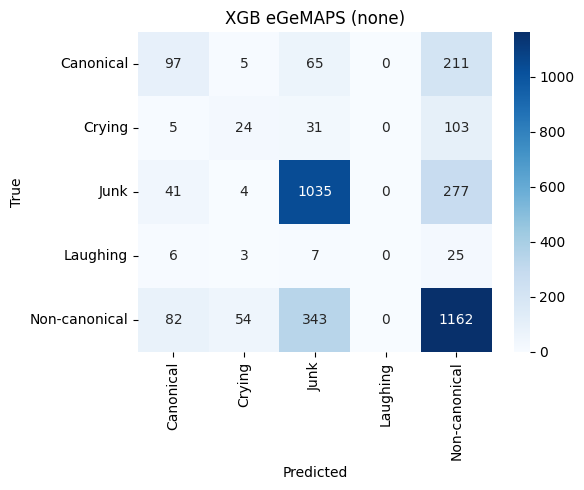

2025/12/07 16:32:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_eGeMAPS_none at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/8ce33ae124b048c79c67c8e62402b23f.
2025/12/07 16:32:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = class_weights
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  Using class weights: {np.int64(0): np.float64(1.6216216216216217), np.int64(1): np.float64(2.962962962962963), np.int64(2): np.float64(0.5034965034965035), np.int64(3): np.float64(15.652173913043478), np.int64(4): np.float64(0.5010438413361169)}

=== XGBoost on eGeMAPS | imbalance=class_weights ===
Accuracy: 0.6302
Weighted F1: 0.6293300127747771
Weighted Precision: 0.6314271825676515
Weighted Recall: 0.6301675977653631
UAR: 0.4229983531780236


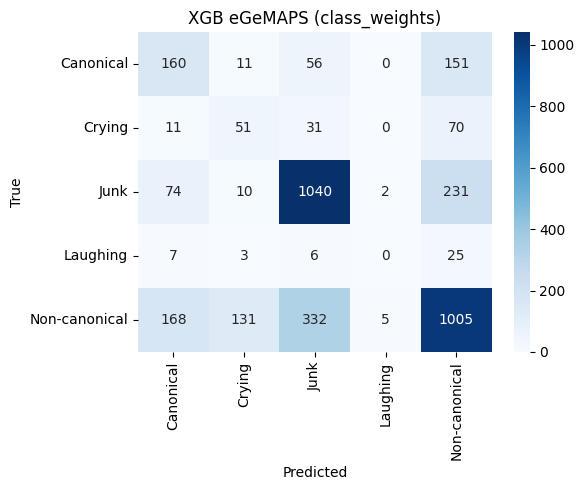

2025/12/07 16:32:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_eGeMAPS_class_weights at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/e35786633b584cc5b2827e58148ef4e0.
2025/12/07 16:32:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = smote
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(1): 1437, np.int64(3): 1437, np.int64(0): 1437, np.int64(4): 1437, np.int64(2): 1437})

=== XGBoost on eGeMAPS | imbalance=smote ===
Accuracy: 0.6260
Weighted F1: 0.6281587452097633
Weighted Precision: 0.6332114793090439
Weighted Recall: 0.6259776536312849
UAR: 0.43345927013324204


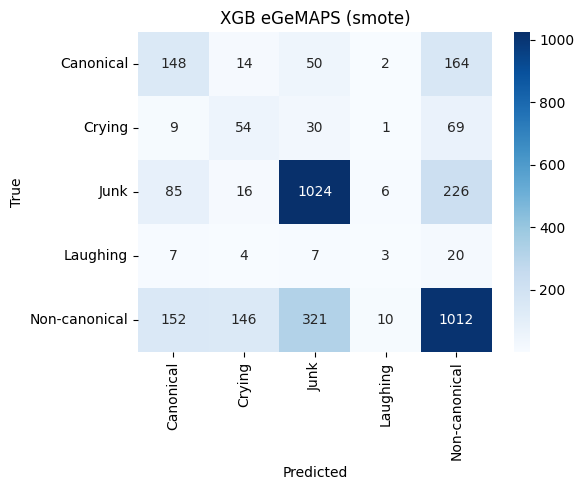

2025/12/07 16:32:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_eGeMAPS_smote at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/81f970cfe6f048e78b2eb4480ee32a76.
2025/12/07 16:32:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = smote_tomek
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(3): 1435, np.int64(1): 1428, np.int64(0): 1415, np.int64(2): 1293, np.int64(4): 1284})

=== XGBoost on eGeMAPS | imbalance=smote_tomek ===
Accuracy: 0.6120
Weighted F1: 0.6174042536545489
Weighted Precision: 0.626959075441839
Weighted Recall: 0.6120111731843575
UAR: 0.4394383217843044


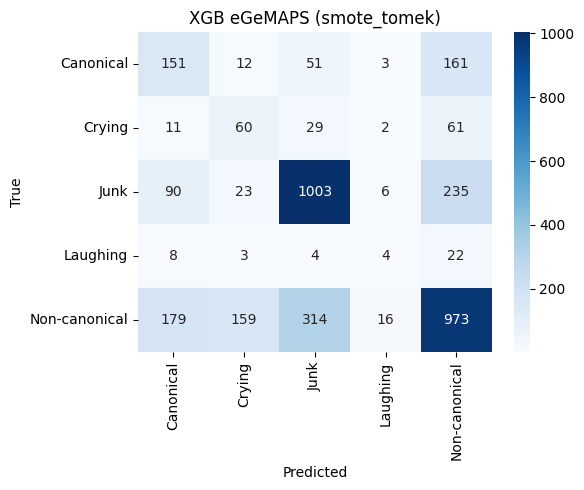

2025/12/07 16:33:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_eGeMAPS_smote_tomek at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/cc71546f371f4701a5dfa4685690d7b1.
2025/12/07 16:33:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = undersampling
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(0): 46, np.int64(1): 46, np.int64(2): 46, np.int64(3): 46, np.int64(4): 46})

=== XGBoost on eGeMAPS | imbalance=undersampling ===
Accuracy: 0.4056
Weighted F1: 0.44091174873428723
Weighted Precision: 0.5865199453659656
Weighted Recall: 0.40558659217877097
UAR: 0.4308336248826965


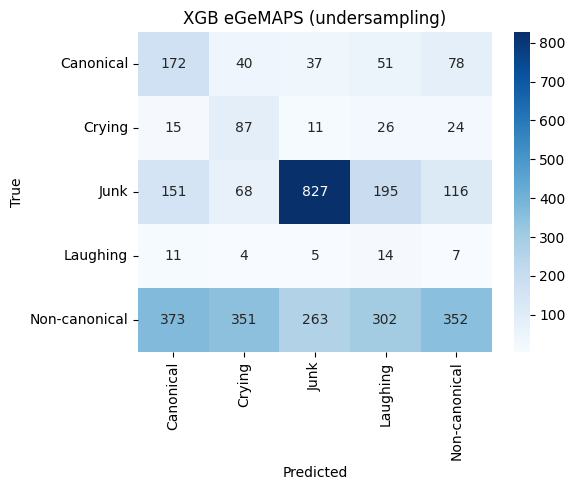

2025/12/07 16:33:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_eGeMAPS_undersampling at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/8c6f5ca61af2454d95f19b84ff75dcc2.
2025/12/07 16:33:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = smote_enn
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(3): 1401, np.int64(1): 1311, np.int64(0): 1104, np.int64(2): 360, np.int64(4): 116})

=== XGBoost on eGeMAPS | imbalance=smote_enn ===
Accuracy: 0.3763
Weighted F1: 0.37883500831925015
Weighted Precision: 0.6558820024619447
Weighted Recall: 0.37625698324022344
UAR: 0.47179093139681594


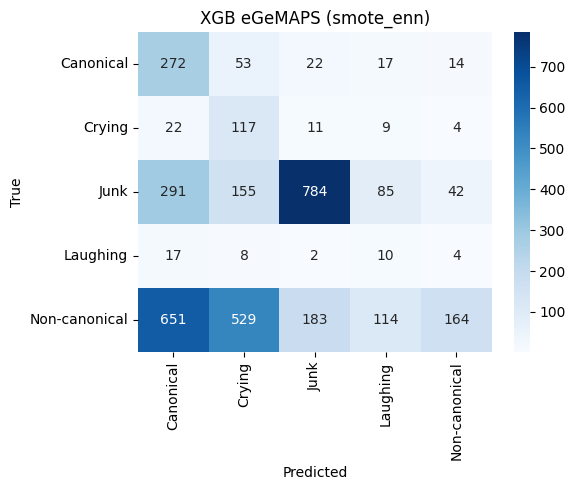

2025/12/07 16:33:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_eGeMAPS_smote_enn at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/1e488acb3ba14db9a39d8010c26c9763.
2025/12/07 16:33:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = none
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})

=== XGBoost on BoAW | imbalance=none ===
Accuracy: 0.5439
Weighted F1: 0.5170186186359602
Weighted Precision: 0.5122153381707801
Weighted Recall: 0.5438547486033519
UAR: 0.299752394842187


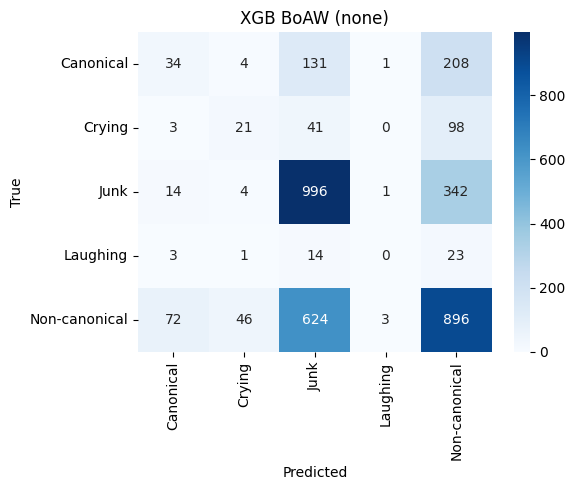

2025/12/07 16:34:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_BoAW_none at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/4d502c62314145ad9107257b858b7842.
2025/12/07 16:34:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = class_weights
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  Using class weights: {np.int64(0): np.float64(1.6216216216216217), np.int64(1): np.float64(2.962962962962963), np.int64(2): np.float64(0.5034965034965035), np.int64(3): np.float64(15.652173913043478), np.int64(4): np.float64(0.5010438413361169)}

=== XGBoost on BoAW | imbalance=class_weights ===
Accuracy: 0.4654
Weighted F1: 0.4711510595457493
Weighted Precision: 0.5222293615047275
Weighted Recall: 0.4653631284916201
UAR: 0.3572193032070888


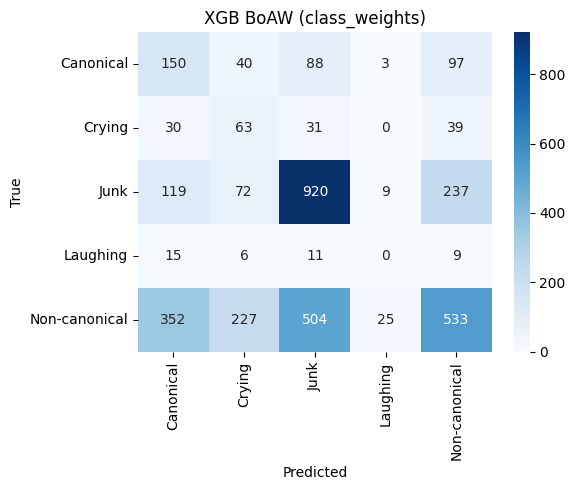

2025/12/07 16:34:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_BoAW_class_weights at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/54b58965ab6b417d972105bea06e825b.
2025/12/07 16:34:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = smote
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(1): 1437, np.int64(3): 1437, np.int64(0): 1437, np.int64(4): 1437, np.int64(2): 1437})

=== XGBoost on BoAW | imbalance=smote ===
Accuracy: 0.5218
Weighted F1: 0.5091511280614226
Weighted Precision: 0.508934637336145
Weighted Recall: 0.5217877094972067
UAR: 0.31705612150518864


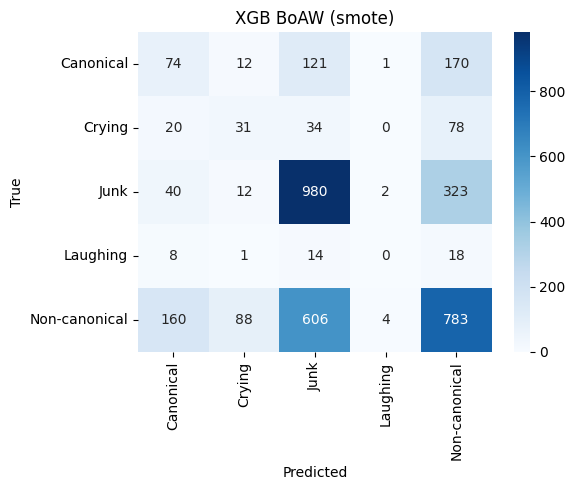

2025/12/07 16:34:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_BoAW_smote at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/00d50bc7982749fa9b0740845ca85f83.
2025/12/07 16:34:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = smote_tomek
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(3): 1437, np.int64(1): 1434, np.int64(0): 1428, np.int64(2): 1308, np.int64(4): 1302})

=== XGBoost on BoAW | imbalance=smote_tomek ===
Accuracy: 0.5215
Weighted F1: 0.5104815407964968
Weighted Precision: 0.5142824089367979
Weighted Recall: 0.5215083798882681
UAR: 0.32102189550733795


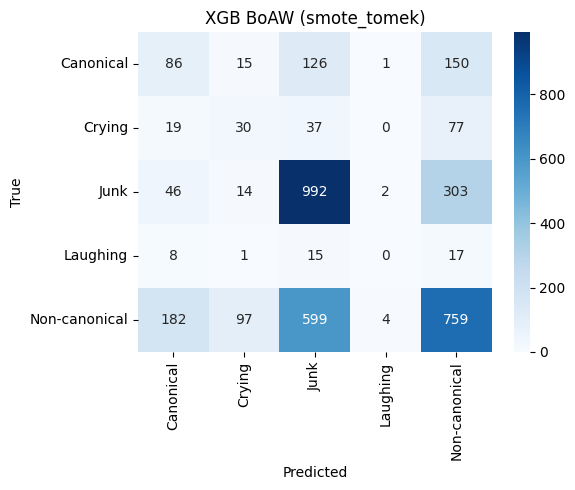

2025/12/07 16:34:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_BoAW_smote_tomek at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/30470b34e8bb46efaf139be8b35f90ca.
2025/12/07 16:34:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = undersampling
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(0): 46, np.int64(1): 46, np.int64(2): 46, np.int64(3): 46, np.int64(4): 46})

=== XGBoost on BoAW | imbalance=undersampling ===
Accuracy: 0.2159
Weighted F1: 0.2590237426016616
Weighted Precision: 0.4184240823795913
Weighted Recall: 0.21592178770949721
UAR: 0.24132127294110006


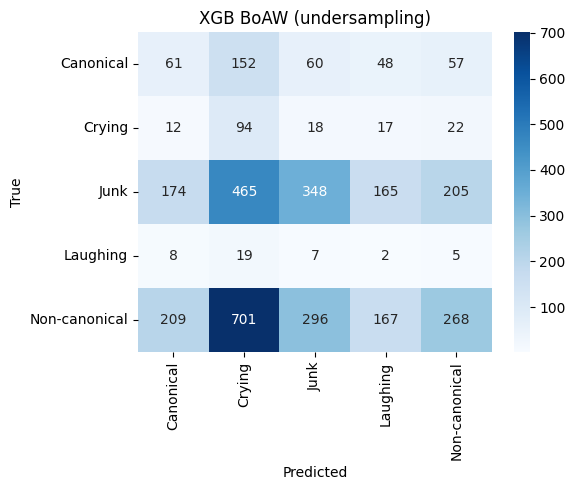

2025/12/07 16:35:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_BoAW_undersampling at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/e5425f4b366448be9999125c70486554.
2025/12/07 16:35:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = smote_enn
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(3): 1437, np.int64(1): 1339, np.int64(0): 1232, np.int64(2): 275, np.int64(4): 132})

=== XGBoost on BoAW | imbalance=smote_enn ===
Accuracy: 0.2475
Weighted F1: 0.2325684796189532
Weighted Precision: 0.568008875503446
Weighted Recall: 0.24748603351955306
UAR: 0.31176307030250433


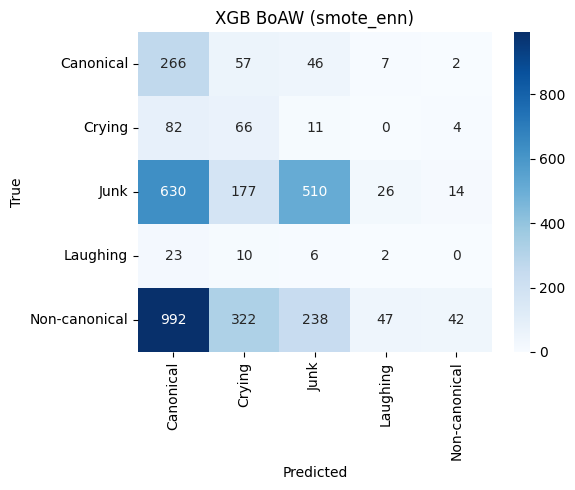

2025/12/07 16:35:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_BoAW_smote_enn at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/7ed43d56d4f340698da065114c6ddce0.
2025/12/07 16:35:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = none
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})

=== XGBoost on FisherVec | imbalance=none ===
Accuracy: 0.6218
Weighted F1: 0.5833198017595551
Weighted Precision: 0.5775715135303624
Weighted Recall: 0.6217877094972067
UAR: 0.3220891791765276


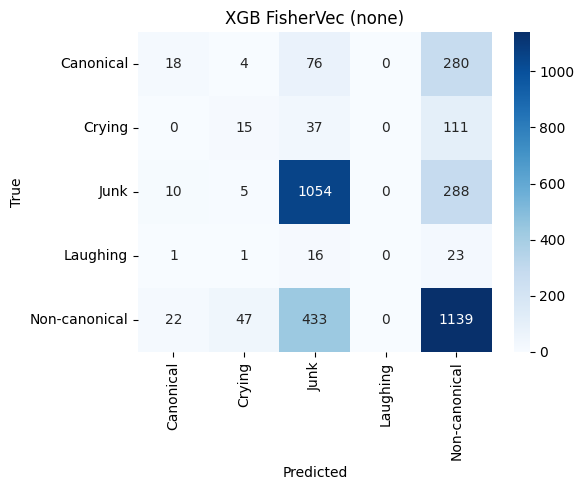

2025/12/07 16:36:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_FisherVec_none at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/2466677d6cce403b99c11f26f63f4307.
2025/12/07 16:36:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = class_weights
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  Using class weights: {np.int64(0): np.float64(1.6216216216216217), np.int64(1): np.float64(2.962962962962963), np.int64(2): np.float64(0.5034965034965035), np.int64(3): np.float64(15.652173913043478), np.int64(4): np.float64(0.5010438413361169)}

=== XGBoost on FisherVec | imbalance=class_weights ===
Accuracy: 0.6078
Weighted F1: 0.5887734510783981
Weighted Precision: 0.5794037608490804
Weighted Recall: 0.6078212290502794
UAR: 0.35520761323705274


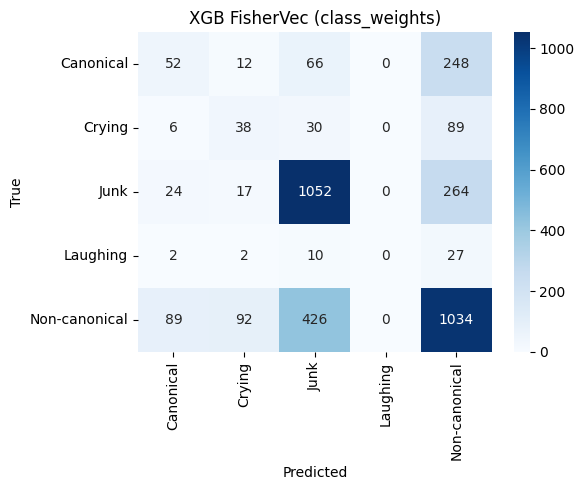

2025/12/07 16:36:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_FisherVec_class_weights at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/5c8cd497aa9f4749979dc9fd6df78f16.
2025/12/07 16:36:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = smote
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(1): 1437, np.int64(3): 1437, np.int64(0): 1437, np.int64(4): 1437, np.int64(2): 1437})

=== XGBoost on FisherVec | imbalance=smote ===
Accuracy: 0.5936
Weighted F1: 0.5855090850177026
Weighted Precision: 0.5818101375971714
Weighted Recall: 0.5935754189944135
UAR: 0.3656435934927477


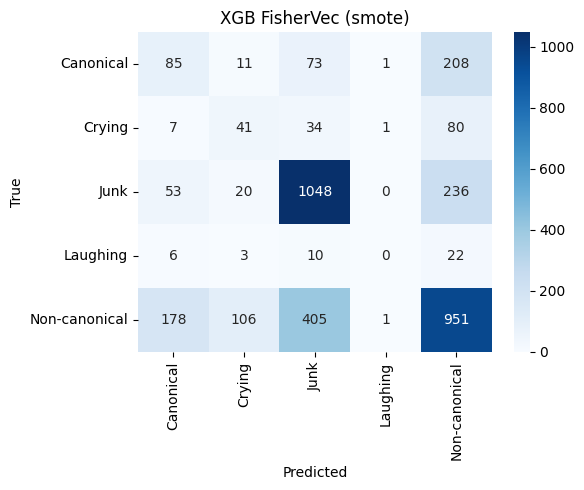

2025/12/07 16:37:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_FisherVec_smote at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/6116fd88548c48ffa99c93c8df80cc2f.
2025/12/07 16:37:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = smote_tomek
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(1): 1437, np.int64(3): 1437, np.int64(0): 1436, np.int64(2): 1367, np.int64(4): 1366})

=== XGBoost on FisherVec | imbalance=smote_tomek ===
Accuracy: 0.5925
Weighted F1: 0.5849526372843833
Weighted Precision: 0.5823440572598497
Weighted Recall: 0.5924581005586592
UAR: 0.3663777567497629


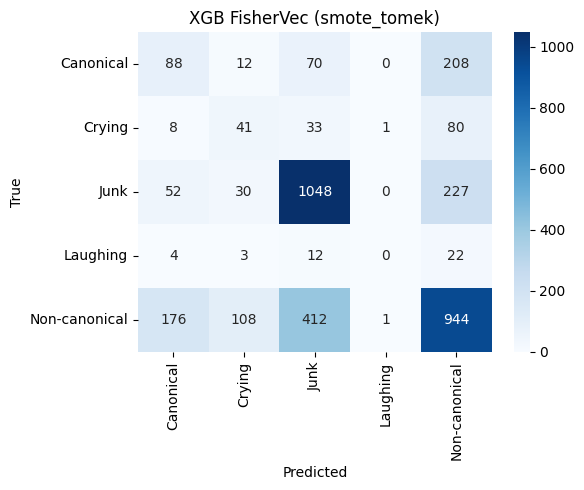

2025/12/07 16:38:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_FisherVec_smote_tomek at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/087710ec2553476793be42d9adc7881a.
2025/12/07 16:38:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = undersampling
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(0): 46, np.int64(1): 46, np.int64(2): 46, np.int64(3): 46, np.int64(4): 46})

=== XGBoost on FisherVec | imbalance=undersampling ===
Accuracy: 0.3626
Weighted F1: 0.3907187136515996
Weighted Precision: 0.5115214321740108
Weighted Recall: 0.3625698324022346
UAR: 0.35778134162748115


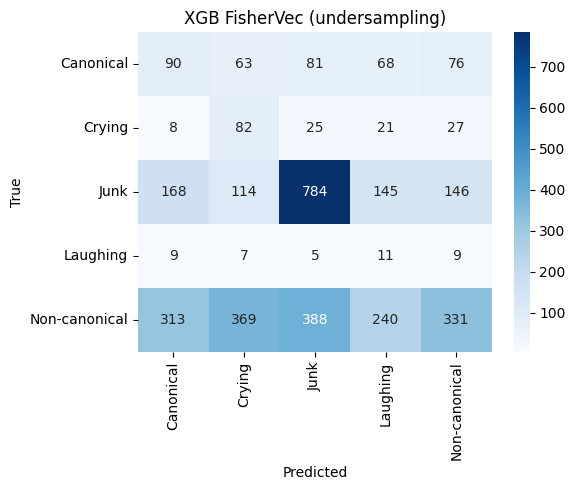

2025/12/07 16:39:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_FisherVec_undersampling at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/37f80ec0abf64dd8ae41286ab0b6f38f.
2025/12/07 16:39:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = smote_enn
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(3): 1437, np.int64(1): 1424, np.int64(0): 1313, np.int64(2): 240, np.int64(4): 69})

=== XGBoost on FisherVec | imbalance=smote_enn ===
Accuracy: 0.2905
Weighted F1: 0.26489016843751173
Weighted Precision: 0.587037297133436
Weighted Recall: 0.2905027932960894
UAR: 0.398996452200774


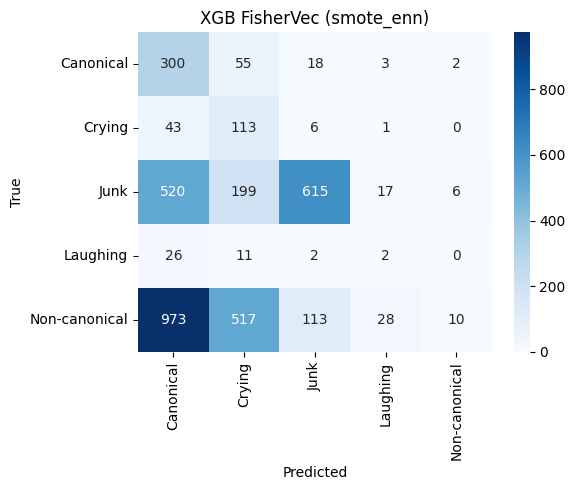

2025/12/07 16:39:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_FisherVec_smote_enn at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/d91d3d89b2b2465f8ab7676c3e4e75a8.
2025/12/07 16:39:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = none
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})

=== XGBoost on ResNet50 | imbalance=none ===
Accuracy: 0.6360
Weighted F1: 0.5959640211867243
Weighted Precision: 0.5912369041090785
Weighted Recall: 0.6360335195530726
UAR: 0.3223388124801726


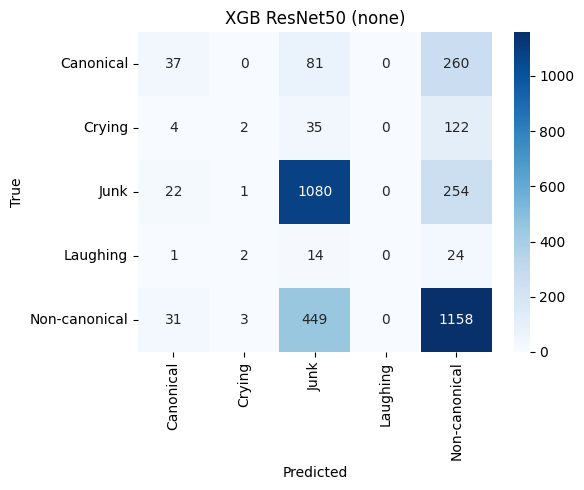

2025/12/07 16:42:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_ResNet50_none at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/3baab64b25a14eb1a0336dd396468b24.
2025/12/07 16:42:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = class_weights
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  Using class weights: {np.int64(0): np.float64(1.6216216216216217), np.int64(1): np.float64(2.962962962962963), np.int64(2): np.float64(0.5034965034965035), np.int64(3): np.float64(15.652173913043478), np.int64(4): np.float64(0.5010438413361169)}

=== XGBoost on ResNet50 | imbalance=class_weights ===
Accuracy: 0.6260
Weighted F1: 0.6010381274435964
Weighted Precision: 0.5913000493053161
Weighted Recall: 0.6259776536312849
UAR: 0.3430467507337128


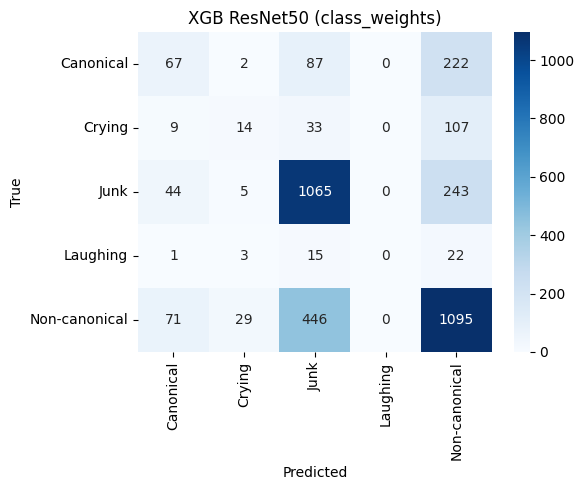

2025/12/07 16:44:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_ResNet50_class_weights at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/fb78a954140e4fa3a37696ac040134ab.
2025/12/07 16:44:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = smote
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(1): 1437, np.int64(3): 1437, np.int64(0): 1437, np.int64(4): 1437, np.int64(2): 1437})

=== XGBoost on ResNet50 | imbalance=smote ===
Accuracy: 0.6198
Weighted F1: 0.5950592406720401
Weighted Precision: 0.5865461043841371
Weighted Recall: 0.6198324022346369
UAR: 0.34099692345407123


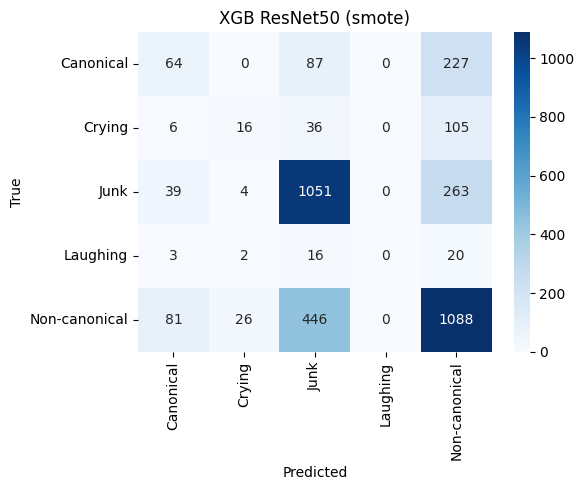

2025/12/07 16:47:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_ResNet50_smote at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/1c8a04b4497a42d0ac88a9bff5d8e5a7.
2025/12/07 16:47:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = smote_tomek
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(3): 1437, np.int64(1): 1436, np.int64(0): 1436, np.int64(4): 1364, np.int64(2): 1362})

=== XGBoost on ResNet50 | imbalance=smote_tomek ===
Accuracy: 0.6226
Weighted F1: 0.5982197444998452
Weighted Precision: 0.5915639653262397
Weighted Recall: 0.6226256983240224
UAR: 0.34589257522922434


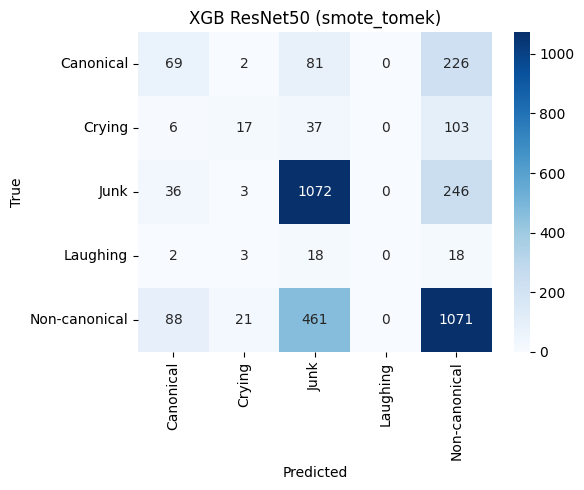

2025/12/07 16:49:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_ResNet50_smote_tomek at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/38610fa757e14f14a16cb92208799ef2.
2025/12/07 16:49:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = undersampling
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(0): 46, np.int64(1): 46, np.int64(2): 46, np.int64(3): 46, np.int64(4): 46})

=== XGBoost on ResNet50 | imbalance=undersampling ===
Accuracy: 0.3441
Weighted F1: 0.3570005753335119
Weighted Precision: 0.5285298427426218
Weighted Recall: 0.34413407821229053
UAR: 0.41792996204079447


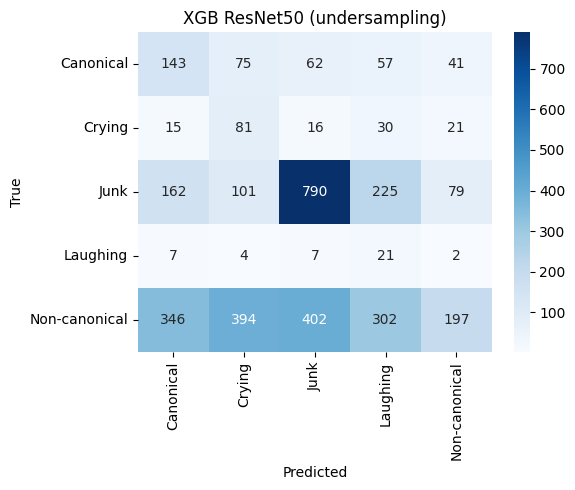

2025/12/07 16:50:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_ResNet50_undersampling at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/1fd8f54bf84049a3adaf4dd9b2e9a9de.
2025/12/07 16:50:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = smote_enn
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(3): 1437, np.int64(1): 1406, np.int64(0): 1275, np.int64(2): 261, np.int64(4): 47})

=== XGBoost on ResNet50 | imbalance=smote_enn ===
Accuracy: 0.3170
Weighted F1: 0.28519939377636166
Weighted Precision: 0.6190174431126932
Weighted Recall: 0.3170391061452514
UAR: 0.3762598178293862


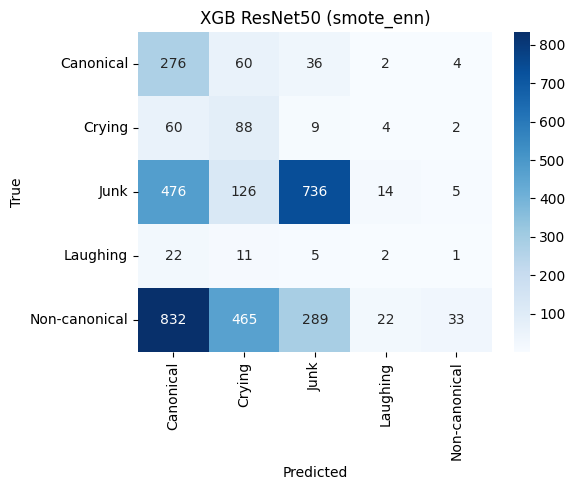

2025/12/07 16:52:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_ResNet50_smote_enn at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/882eb31b9ab84b80af9239340f821d3a.
2025/12/07 16:52:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.


,feature,imbalance_method,accuracy,f1,precision,recall,uar
0,eGeMAPS,none,0.647486,0.630323,0.620950,0.647486,0.374934
1,eGeMAPS,class_weights,0.630168,0.629330,0.631427,0.630168,0.422998
2,eGeMAPS,smote,0.625978,0.628159,0.633211,0.625978,0.433459
3,eGeMAPS,smote_tomek,0.612011,0.617404,0.626959,0.612011,0.439438
4,eGeMAPS,undersampling,0.405587,0.440912,0.586520,0.405587,0.430834
5,eGeMAPS,smote_enn,0.376257,0.378835,0.655882,0.376257,0.471791
6,BoAW,none,0.543855,0.517019,0.512215,0.543855,0.299752
7,BoAW,class_weights,0.465363,0.471151,0.522229,0.465363,0.357219
8,BoAW,smote,0.521788,0.509151,0.508935,0.521788,0.317056
9,BoAW,smote_tomek,0.521508,0.510482,0.514282,0.521508,0.321022


In [ ]:
feature_map = {
    "eGeMAPS":    (X_train_egemaps, X_valid_egemaps),
    "BoAW":       (X_train_boaw, X_valid_boaw),
    "FisherVec":  (X_train_fv, X_valid_fv),
    #"PANNs":      (X_train_panns, X_valid_panns),
    "ResNet50":   (X_train_resnet, X_valid_resnet),
}

imbalance_methods = [
    "none",
    "class_weights",
    "smote",
    "smote_tomek",
    "undersampling",
    "smote_enn",
]

results_table = []

for feat_name, (Xtr, Xval) in feature_map.items():
    for imb in imbalance_methods:
        acc, metrics = run_xgb_experiment_for_feature(
            feature_name=feat_name,
            X_train_raw=Xtr,
            X_valid_raw=Xval,
            imbalance_method=imb,
        )
        results_table.append({
            "feature": feat_name,
            "imbalance_method": imb,
            "accuracy": acc,
            "f1": metrics.f1_score,
            "precision": metrics.precision_score,
            "recall": metrics.recall_score,
            "uar": metrics.uar,
        })

results_df = pd.DataFrame(results_table)
results_df



[Imbalance] Method = smote
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(1): 1437, np.int64(3): 1437, np.int64(0): 1437, np.int64(4): 1437, np.int64(2): 1437})

=== XGBoost on eGeMAPS | imbalance=smote ===
Accuracy: 0.6260
Weighted F1: 0.6281587452097633
Weighted Precision: 0.6332114793090439
Weighted Recall: 0.6259776536312849
UAR: 0.43345927013324204


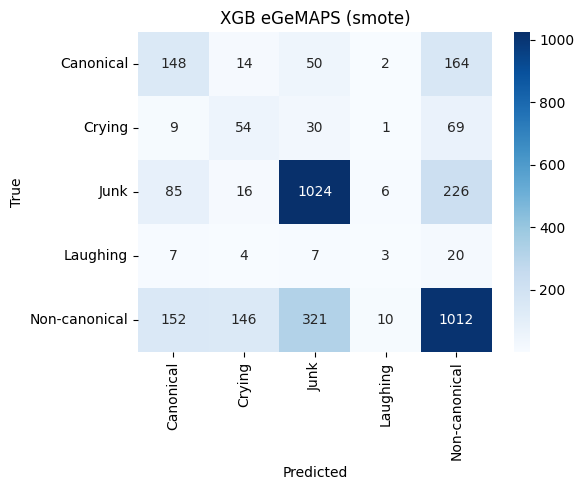

2025/12/07 11:38:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_eGeMAPS_smote at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/6b23e217afce49089cf6d3c70ef97666.
2025/12/07 11:38:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = smote_tomek
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(3): 1435, np.int64(1): 1428, np.int64(0): 1415, np.int64(2): 1293, np.int64(4): 1284})

=== XGBoost on eGeMAPS | imbalance=smote_tomek ===
Accuracy: 0.6120
Weighted F1: 0.6174042536545489
Weighted Precision: 0.626959075441839
Weighted Recall: 0.6120111731843575
UAR: 0.4394383217843044


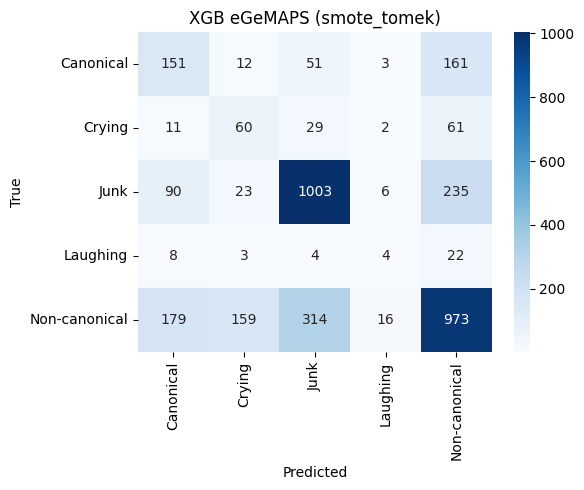

2025/12/07 11:38:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_eGeMAPS_smote_tomek at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/ec01ac9d4b2d4f2098132c66d3b9882a.
2025/12/07 11:38:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = undersampling
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(0): 46, np.int64(1): 46, np.int64(2): 46, np.int64(3): 46, np.int64(4): 46})

=== XGBoost on eGeMAPS | imbalance=undersampling ===
Accuracy: 0.4056
Weighted F1: 0.44091174873428723
Weighted Precision: 0.5865199453659656
Weighted Recall: 0.40558659217877097
UAR: 0.4308336248826965


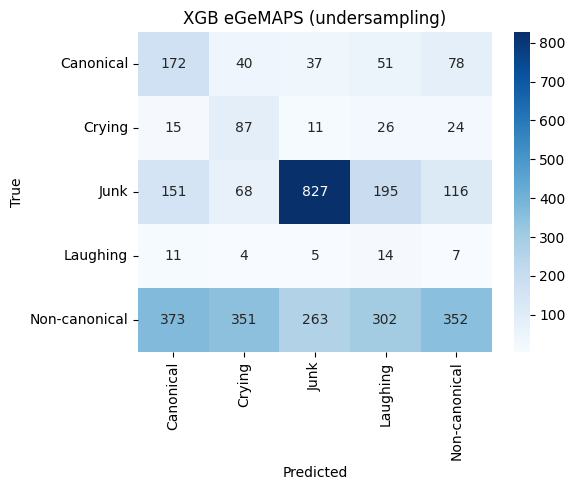

2025/12/07 11:38:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_eGeMAPS_undersampling at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/31c13c2f403e470b8ec2e48abd0198a8.
2025/12/07 11:38:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = smote_enn
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(3): 1401, np.int64(1): 1311, np.int64(0): 1104, np.int64(2): 360, np.int64(4): 116})

=== XGBoost on eGeMAPS | imbalance=smote_enn ===
Accuracy: 0.3763
Weighted F1: 0.37883500831925015
Weighted Precision: 0.6558820024619447
Weighted Recall: 0.37625698324022344
UAR: 0.47179093139681594


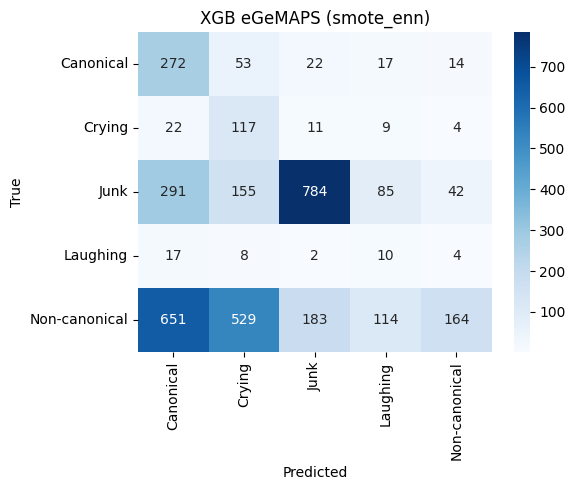

2025/12/07 11:39:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_eGeMAPS_smote_enn at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/41b914c85026474baa214884719f8d46.
2025/12/07 11:39:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.


,feature,imbalance_method,accuracy,f1,precision,recall,uar
0,eGeMAPS,smote,0.625978,0.628159,0.633211,0.625978,0.433459
1,eGeMAPS,smote_tomek,0.612011,0.617404,0.626959,0.612011,0.439438
2,eGeMAPS,undersampling,0.405587,0.440912,0.586520,0.405587,0.430834
3,eGeMAPS,smote_enn,0.376257,0.378835,0.655882,0.376257,0.471791


In [33]:
feature_map = {
    "eGeMAPS":    (X_train_egemaps, X_valid_egemaps)
    }

imbalance_methods = [
    "smote",
    "smote_tomek",
    "undersampling",
    "smote_enn",
]

results_table = []

for feat_name, (Xtr, Xval) in feature_map.items():
    for imb in imbalance_methods:
        acc, metrics = run_xgb_experiment_for_feature(
            feature_name=feat_name,
            X_train_raw=Xtr,
            X_valid_raw=Xval,
            imbalance_method=imb,
        )
        results_table.append({
            "feature": feat_name,
            "imbalance_method": imb,
            "accuracy": acc,
            "f1": metrics.f1_score,
            "precision": metrics.precision_score,
            "recall": metrics.recall_score,
            "uar": metrics.uar,
        })

results_df = pd.DataFrame(results_table)
results_df



[Imbalance] Method = smote_then_tomek
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  After SMOTE: Counter({np.int64(1): 1437, np.int64(3): 1437, np.int64(0): 1437, np.int64(4): 1437, np.int64(2): 1437})
  New class distribution: Counter({np.int64(0): 1437, np.int64(3): 1435, np.int64(1): 1428, np.int64(2): 1293, np.int64(4): 1284})

=== XGBoost on eGeMAPS | imbalance=smote_then_tomek ===
Accuracy: 0.6103
Weighted F1: 0.6173388507370124
Weighted Precision: 0.6284119985493388
Weighted Recall: 0.6103351955307262
UAR: 0.4330539404007022


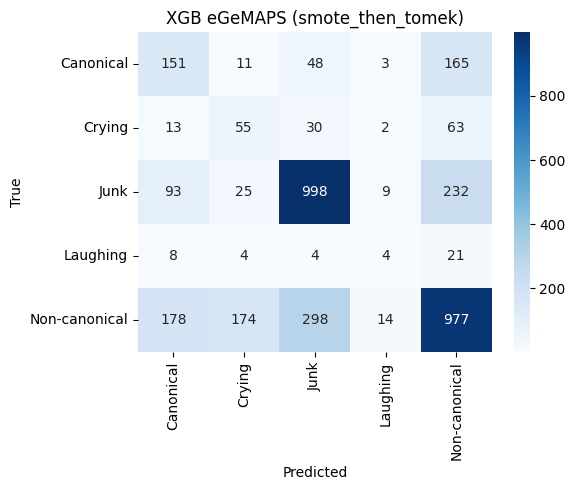

2025/12/08 12:07:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_eGeMAPS_smote_then_tomek at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/e98aea0738de4e0cbdc9b7343d73e973.
2025/12/08 12:07:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = hybrid
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
[HybridSampler] Original: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
[HybridSampler] SMOTE target: {0: 900, 1: 900, 2: 1430, 3: 800, 4: 1437}
[HybridSampler] Final target: {0: 900, 1: 900, 2: 1400, 3: 800, 4: 1200}
[HybridSampler] After SMOTE: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(1): 900, np.int64(0): 900, np.int64(3): 800})
[HybridSampler] After undersampling: Counter({np.int64(2): 1400, np.int64(4): 1200, np.int64(0): 900, np.int64(1): 900, np.int64(3): 800})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1253, np.int64(4): 1051, np.int64(1): 894, np.int64(0): 863, np.int64(3): 800})
  New class distribution: Counter({np.int64(2): 1253, np.int64(4): 1051, np.int64(1): 894, np.int64(0): 863, np.int64(3): 800})

=== XGBoost on eGeMAPS | imbala

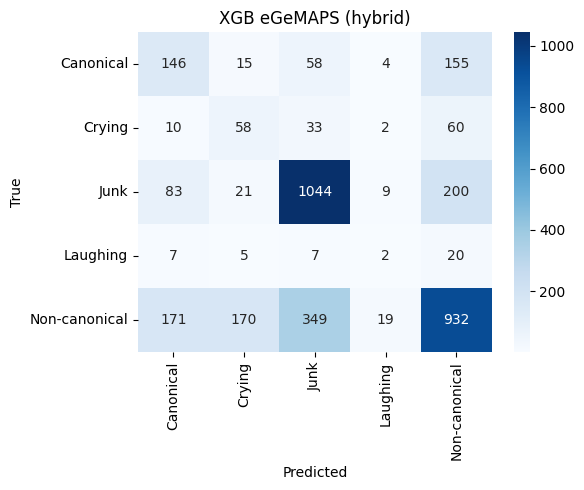

2025/12/08 12:08:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_eGeMAPS_hybrid at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/659c5348230842119c9b072a353c1fe5.
2025/12/08 12:08:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.


,feature,imbalance_method,accuracy,f1,precision,recall,uar
0,eGeMAPS,smote_then_tomek,0.610335,0.617339,0.628412,0.610335,0.433054
1,eGeMAPS,hybrid,0.609497,0.613551,0.625349,0.609497,0.425629


In [62]:
feature_map = {
    "eGeMAPS":    (X_train_egemaps, X_valid_egemaps),
    #"BoAW":       (X_train_boaw, X_valid_boaw),
    #"FisherVec":  (X_train_fv, X_valid_fv),
    #"PANNs":      (X_train_panns, X_valid_panns),
    #"ResNet50":   (X_train_resnet, X_valid_resnet),
}

imbalance_methods = [
    "smote_then_tomek",
    "hybrid",
    #"none",
    #"class_weights",
    #"smote",
    #"smote_tomek",
    #"undersampling",
    #"smote_enn",
]

results_table = []

for feat_name, (Xtr, Xval) in feature_map.items():
    for imb in imbalance_methods:
        acc, metrics = run_xgb_experiment_for_feature(
            feature_name=feat_name,
            X_train_raw=Xtr,
            X_valid_raw=Xval,
            imbalance_method=imb,
        )
        results_table.append({
            "feature": feat_name,
            "imbalance_method": imb,
            "accuracy": acc,
            "f1": metrics.f1_score,
            "precision": metrics.precision_score,
            "recall": metrics.recall_score,
            "uar": metrics.uar,
        })

results_df = pd.DataFrame(results_table)
results_df